In [1]:
import pandas as pd
import pandasql as pdsql
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt

pysql = lambda q: pdsql.sqldf(q, globals())

data = pd.read_csv('data/amico-export.csv.gz', compression='gzip')


In [2]:
# data = data.loc[data['type'] == 'DMG']

In [3]:
data['date'] = pd.to_datetime(data['date'])
data['vt_query'] = pd.to_datetime(data['vt_query'])
data.dtypes

dump_id              int64
date        datetime64[ns]
md5                 object
host                object
server              object
type                object
max_tavs           float64
max_avs            float64
score              float64
vt_query    datetime64[ns]
dtype: object

In [4]:
sql_query = """
    SELECT type, 
           count(*) as count, 
           count(distinct md5) as dist_md5, 
           count(distinct host) as dist_host, 
           count(distinct server) as dist_servIP 
    FROM data 
    GROUP BY type 
    ORDER BY type;
    """

type_dist = pysql(sql_query)
type_dist



,type,count,dist_md5,dist_host,dist_servIP
0,APK,35446,934,372,603
1,DMG,24564,2828,1240,1034
2,EXE,83175,6112,1205,3525
3,JAR,118424,5931,393,1277


In [9]:
sql_query = """
    SELECT type, max_tavs,
           count(*) as count, 
           count(distinct host) as dist_host, 
           count(distinct server) as dist_servIP 
    FROM data
    where max_avs = 0 
    GROUP BY type 
    ORDER BY type, max_tavs DESC;
    """

mal_type_dist = pysql(sql_query)
mal_type_dist

,type,max_tavs,count,dist_host,dist_servIP
0,APK,0.0,33123,90,408
1,DMG,0.0,16293,105,227
2,EXE,0.0,58021,608,2258
3,JAR,0.0,111441,284,1133


In [6]:

def label_downloads(avs_count, threshold, avs_count1):
    if len(avs_count1) > 1:
        labels = ['benign']*len(avs_count)
        for i in range(len(avs_count)):
            if avs_count[i] >= threshold : 
                labels[i] = 'malware'
            elif ((avs_count1[i] > 0) and (avs_count[i] < 2)) :
                labels[i] = 'unknown'
    else :
        labels = ['benign']*len(avs_count)
        for i in range(len(avs_count)):
            if avs_count[i] >= threshold : 
                labels[i] = 'malware'
            elif (avs_count[i] > 0) :
                labels[i] = 'unknown'
    return labels


sql_query = """
    SELECT md5, host, score, max_tavs, max_avs
    FROM data
    WHERE max_avs IS NOT NULL AND type = 'DMG'
    ORDER BY date;
    """
scores = pysql(sql_query)

threshold = 1
avs_count = scores['max_tavs']
avs_count1 = scores['max_avs']
scores['tavs1_labs'] = label_downloads(avs_count,threshold, avs_count1)


threshold = 2
avs_count = scores['max_tavs']
avs_count1 = scores['max_avs']
scores['tavs2_labs'] = label_downloads(avs_count,threshold, avs_count1)

avs_count1 = []
threshold = 5
avs_count = scores['max_avs']
scores['avs5_labs'] = label_downloads(avs_count,threshold, avs_count1)

avs_count1 = []
threshold = 2
avs_count = scores['max_avs']
scores['avs2_labs'] = label_downloads(avs_count,threshold, avs_count1)

print (scores)

                                    md5  \
0      f95e436b8c5b953ead1db3ab929d9c8f   
1      f95e436b8c5b953ead1db3ab929d9c8f   
2      f95e436b8c5b953ead1db3ab929d9c8f   
3      f95e436b8c5b953ead1db3ab929d9c8f   
4      f95e436b8c5b953ead1db3ab929d9c8f   
5      53965557a38d61521a2a45a60abcaafe   
6      f95e436b8c5b953ead1db3ab929d9c8f   
7      f95e436b8c5b953ead1db3ab929d9c8f   
8      f95e436b8c5b953ead1db3ab929d9c8f   
9      f95e436b8c5b953ead1db3ab929d9c8f   
10     f95e436b8c5b953ead1db3ab929d9c8f   
11     f95e436b8c5b953ead1db3ab929d9c8f   
12     f95e436b8c5b953ead1db3ab929d9c8f   
13     f95e436b8c5b953ead1db3ab929d9c8f   
14     1f764adb154f98190e5608cc8ab4a87c   
15     f95e436b8c5b953ead1db3ab929d9c8f   
16     e514a588b271543c3679ab10d8546ee1   
17     f95e436b8c5b953ead1db3ab929d9c8f   
18     85d758a56231e064b0df0e7673ff8c37   
19     f95e436b8c5b953ead1db3ab929d9c8f   
20     f95e436b8c5b953ead1db3ab929d9c8f   
21     f95e436b8c5b953ead1db3ab929d9c8f   
22     f95e

In [7]:
print ("Number of downloads =", len(scores['md5']))
print ("Number of distinct md5s =", len(set(scores['md5'])))
print ("Number of distinct domains =", len(set(scores['host'])))

Number of downloads = 21579
Number of distinct md5s = 475
Number of distinct domains = 229


In [8]:
from collections import Counter

md5_count = Counter(scores['md5'])
host_count = Counter(scores['host'])


In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_count_hist(count, pdf_file='hist.pdf'):
    labels, values = zip(*count.items())
    indexes = np.arange(len(labels))

    width = 1
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels, rotation='vertical')
    plt.savefig(pdf_file)
    plt.show()

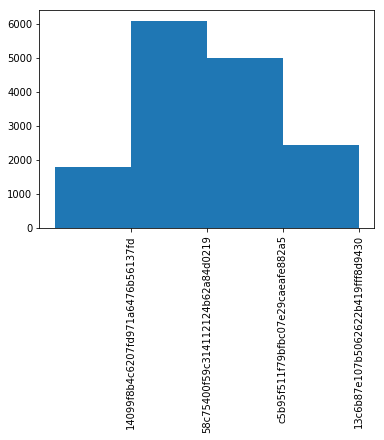

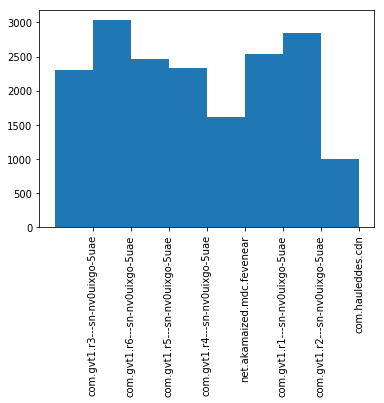

In [10]:
def filter_count(count_dict, th=0):
    new_dict = dict()
    for k in count_dict:
        if count_dict[k] > th:
            new_dict[k] = count_dict[k]
    return new_dict

md5_count_filtered = filter_count(md5_count,1000)
host_count_filtered = filter_count(host_count,1000)

plot_count_hist(md5_count_filtered, 'data/top_md5s_hist.pdf')
plot_count_hist(host_count_filtered, 'data/top_hosts_hist.png')


In [11]:
from sklearn.metrics import roc_curve, auc

def compute_scores_for_ROC(scores, labels_col_name, md5_filter=set(), host_filter=set()):
    roc_scores = scores.copy()
    # print roc_scores['md5'].isin(md5_filter) == False
    roc_scores = roc_scores.loc[~roc_scores['md5'].isin(md5_filter)]
    roc_scores = roc_scores.loc[~roc_scores['host'].isin(host_filter)]

    roc_scores = roc_scores[['score',labels_col_name]]
    roc_scores = roc_scores.loc[roc_scores[labels_col_name] != 'unknown']
    roc_scores = roc_scores.loc[~roc_scores['score'].isnull()]
    
    roc_scores.columns = ['score','labels']
    return roc_scores


curve_labels = ['tavs1','tavs2','avs2','avs5']

labs = dict()
fpr = dict()
tpr = dict()
th = dict()

md5_filter = set()
host_filter = set()

for k in curve_labels:
    labs[k] = compute_scores_for_ROC(scores, k+'_labs', md5_filter, host_filter)
    fpr[k], tpr[k], th[k] = roc_curve(labs[k]['labels'], labs[k]['score'], pos_label='malware')
    print ("Non filtered:", k, len(labs[k]))
    
    

labs_fm = dict()
fpr_fm = dict()
tpr_fm = dict()
th_fm = dict()
    
md5_filter_th = 100
md5_filter = filter_count(md5_count,md5_filter_th).keys()
host_filter = set() 

for k in curve_labels:
    labs_fm[k] = compute_scores_for_ROC(scores, k+'_labs', md5_filter, host_filter)
    fpr_fm[k], tpr_fm[k], th_fm[k] = roc_curve(labs_fm[k]['labels'], labs_fm[k]['score'], pos_label='malware')
    print ("Filtered (m):", k, len(labs_fm[k]))
    
    
    
labs_fh = dict()
fpr_fh = dict()
tpr_fh = dict()
th_fh = dict()
    
host_filter_th = 1000
md5_filter = set()
host_filter = filter_count(host_count,host_filter_th).keys()

for k in curve_labels:
    labs_fh[k] = compute_scores_for_ROC(scores, k+'_labs', md5_filter, host_filter)
    fpr_fh[k], tpr_fh[k], th_fh[k] = roc_curve(labs_fh[k]['labels'], labs_fh[k]['score'], pos_label='malware')
    print ("Filtered (h):", k, len(labs_fh[k]))
    

                                             

Non filtered: tavs1 20437
Non filtered: tavs2 20399
Non filtered: avs2 20437
Non filtered: avs5 20412
Filtered (m): tavs1 3478
Filtered (m): tavs2 3440
Filtered (m): avs2 3478
Filtered (m): avs5 3453
Filtered (h): tavs1 3360
Filtered (h): tavs2 3322
Filtered (h): avs2 3360
Filtered (h): avs5 3335


<class 'dict'>
<class 'numpy.ndarray'>
<class 'dict'>
<class 'numpy.ndarray'>
<class 'dict'>
<class 'numpy.ndarray'>
<class 'dict'>
<class 'numpy.ndarray'>


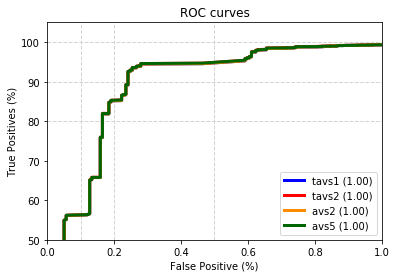

<class 'dict'>
<class 'numpy.ndarray'>
<class 'dict'>
<class 'numpy.ndarray'>
<class 'dict'>
<class 'numpy.ndarray'>
<class 'dict'>
<class 'numpy.ndarray'>


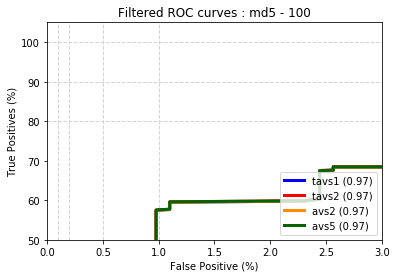

<class 'dict'>
<class 'numpy.ndarray'>
<class 'dict'>
<class 'numpy.ndarray'>
<class 'dict'>
<class 'numpy.ndarray'>
<class 'dict'>
<class 'numpy.ndarray'>


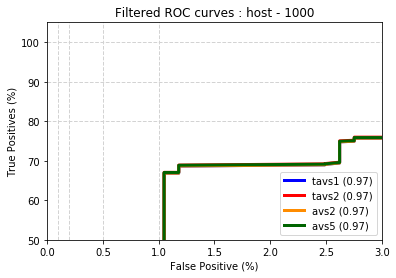

In [14]:
import matplotlib.pyplot as plt

def plot_ROC(fpr, tpr, curves, colors, fpr_max=0.01, title='ROC curves'):
    plt.figure()
    lw = 3

    plt.plot([0, 100], [100, 100], color='lightgray', lw=1, linestyle='--')
    plt.plot([0, 100], [90, 90], color='lightgray', lw=1, linestyle='--')
    plt.plot([0, 100], [80, 80], color='lightgray', lw=1, linestyle='--')
    plt.plot([1.0, 1.0], [50, 105], color='lightgray', lw=1, linestyle='--')
    plt.plot([0.5, 0.5], [50, 105], color='lightgray', lw=1, linestyle='--')
    plt.plot([0.2, 0.2], [50, 105], color='lightgray', lw=1, linestyle='--')
    plt.plot([0.1, 0.1], [50, 105], color='lightgray', lw=1, linestyle='--')
    
    for k in curves:
        print(type(fpr))
        print(type(fpr[k]))
        plt.plot(fpr[k]*100, tpr[k]*100, color=colors[k], lw=lw, label=k + ' (%0.2f)' % auc(fpr[k], tpr[k]))

    plt.xlim([0.0, fpr_max*100])
    plt.ylim([50, 105])
    plt.xlabel('False Positive (%)')
    plt.ylabel('True Positives (%)')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig('data/'+title+'.pdf')
    plt.show()


curve_labels = ['tavs1','tavs2','avs2','avs5']
colors = {'tavs1':'blue','tavs2':'red','avs2':'darkorange','avs5':'darkgreen'}
plot_ROC(fpr, tpr, curve_labels, colors)
plot_ROC(fpr_fm, tpr_fm, curve_labels, colors, fpr_max=0.03, title='Filtered ROC curves : md5 - '+str(md5_filter_th))
plot_ROC(fpr_fh, tpr_fh, curve_labels, colors, fpr_max=0.03, title='Filtered ROC curves : host - '+str(host_filter_th))


In [13]:

k = 'avs5'
roc_df = pd.DataFrame({"fpr":fpr[k], "tpr":tpr[k], "th":th[k]})

t = 0.001
eps = t/10
col='fpr'
print roc_df[(roc_df[col]>t-eps) & (roc_df[col]<t+eps)]

t = 0.002
eps = t/10
col='fpr'
print roc_df[(roc_df[col]>t-eps) & (roc_df[col]<t+eps)]

t = 0.7
eps = t/100
col='th'
print roc_df[(roc_df[col]>t-eps) & (roc_df[col]<t+eps)]


SyntaxError: invalid syntax (<ipython-input-13-874a9cf374c5>, line 8)